### Notes

For downloading a dataset kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
https://www.kaggle.com/docs/api

https://www.youtube.com/watch?v=P47raNuzAW0

### Libaries

In [1]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
import nltk
import ssl
import certifi
from sklearn.model_selection import train_test_split


### SSL for download NLTK stopwords

In [2]:
# Define a function to create an SSL context for HTTPS connections
def create_ssl_context():
    context = ssl.create_default_context(cafile=certifi.where())
    return context

# Set the default HTTPS context to use the SSL context created by the new function
ssl._create_default_https_context = create_ssl_context

# Now attempt to download the NLTK stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mitsoufortunat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Import Data

In [3]:
df = pd.read_csv("IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Simple EDA

<BarContainer object of 2 artists>

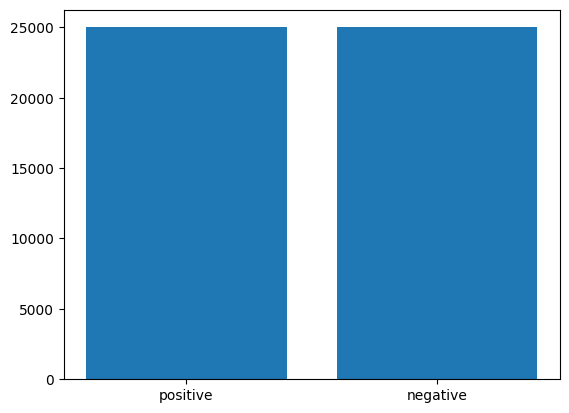

In [5]:
plt.bar(['positive', 'negative'], df.sentiment.value_counts().to_numpy())

### Building the Word embeddor using Gensim

In [6]:
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec

In [15]:
def tokenizer(sentence):
    tokenized_text = simple_preprocess(sentence, deacc=True)
    porter_stemmer = PorterStemmer()
    stemmed_tokens = [porter_stemmer.stem(word) for word in tokenized_text]
    return stemmed_tokens

In [16]:
df['stemmed_tokens'] = df['review'].apply(tokenizer)

In [17]:
w2v_model = Word2Vec(df['stemmed_tokens'], min_count = 1)

In [18]:
w2v_model.save('w2v.model')
w2v_model = Word2Vec.load('w2v.model')

In [19]:
def sent_vec(sent):
    vector_size =w2v_model.wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in w2v_model.wv:
            ctr += 1
            wv_res += w2v_model.wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [20]:
df['vec'] = df['stemmed_tokens'].apply(sent_vec)

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(df['vec'].to_list(), 
                                                    df['sentiment'],
                                                    test_size=0.3)

### Modeling

##### Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

clf_decision_word2vec = DecisionTreeClassifier()
clf_decision_word2vec.fit(X_train, Y_train)


DecisionTreeClassifier()

In [23]:
predicted = clf_decision_word2vec.predict(X_test)

In [24]:
print("DecisionTree Accuracy:",metrics.accuracy_score(Y_test, predicted))

DecisionTree Accuracy: 0.7006666666666667


##### Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(X_train,Y_train)
from sklearn import metrics
predicted = logistic_model.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(Y_test, predicted))


Logistic Regression Accuracy: 0.8528666666666667


##### XGBoost Classifier

In [45]:
from xgboost import XGBClassifier

In [59]:
Y_train_int = (Y_train == "positive").astype(int)
Y_test_int = (Y_test == "positive").astype(int)

In [70]:
XGB_model = XGBClassifier()
XGB_model.fit(X_train,Y_train_int)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [71]:

from sklearn import metrics
predicted = XGB_model.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(Y_test_int, predicted))

Logistic Regression Accuracy: 0.8416


### Predict a new sentence

In [76]:
your_sentence = "I am sad"

In [77]:
sentence_clean = sent_vec(tokenizer(your_sentence))
predicted = logistic_model.predict(sentence_clean.reshape(1, -1))
print("The sentence your wrote is predicted as being " + str(predicted[0]))

The sentence your wrote is predicted as being negative
